# Weghts & Biases

Logging experiments is an important part of serious projects. It makes your results reproducible, easy to visualize, compare and share. Today we will use [Weights & Biases](https://wandb.ai/) library to track our trainings, it is easy to use while doing a lot of stuff automatically.

> Weights & Biases is the machine learning platform for developers to build better models faster. Use W&B's lightweight, interoperable tools to quickly track experiments, version and iterate on datasets, evaluate model performance, reproduce models, visualize results and spot regressions, and share findings with colleagues.

You need to create an account on [Weights & Biases](https://wandb.ai/) to push [special token](https://wandb.ai/authorize) below.

In [63]:
!pip install wandb -q

import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

# Part 1. Machine translation

Today we shall compose encoder-decoder neural networks and apply them to the task of machine translation.

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)
_(img: esciencegroup.files.wordpress.com)_


Encoder-decoder architectures are about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * [Image captioning](http://mscoco.org/dataset/#captions-challenge2015) and [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts

We gonna try our encoder-decoder models on russian to english machine translation problem. More specifically, we'll translate hotel and hostel descriptions. This task shows the scale of machine translation while not requiring you to train your model for weeks if you don't use GPU.

Before we get to the architecture, there's some preprocessing to be done. ~~Go tokenize~~ Alright, this time we've done preprocessing for you. As usual, the data will be tokenized with WordPunctTokenizer.

However, there's one more thing to do. Our data lines contain unique rare words. If we operate on a word level, we will have to deal with large vocabulary size. If instead we use character-level models, it would take lots of iterations to process a sequence. This time we're gonna pick something inbetween.

One popular approach is called [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) aka __BPE__. The algorithm starts with a character-level tokenization and then iteratively merges most frequent pairs for N iterations. This results in frequent words being merged into a single token and rare words split into syllables or even characters.



In [64]:
!pip3 install torch subword-nmt

In [65]:
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/vocab.py -O vocab.py
# thanks to tilda and deephack teams for the data, Dmitry Emelyanenko for the code :)

--2025-12-05 11:58:38--  https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1 [following]
--2025-12-05 11:58:38--  https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8e89c3923d101b61ac3103a34c.dl.dropboxusercontent.com/cd/0/inline/C2dl0hOTfVfEfOo-WaFb11VECwl-LQ7nPX1dLnf-YePbA-AMJ0eMoYcYQxrnW2HtWywizCIRCXqGNR6D87hr8E9XByaM5GTrFQjtJeXiMEF4eAsqNGUIVTq29r7KYONLa9w/file?dl=1# [following]
--2025-12-05 11:58:38--  https://uc8e89c3923d101b61ac3103a34c.dl.dropboxusercontent.com/cd/0/inline/C2dl0hOTfVfEf

In [66]:
!pip install nltk subword_nmt

In [67]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

tokenizer = WordPunctTokenizer()

def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# build and apply bpe vocs
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:26<00:00, 304.82it/s]


### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into words.

In [68]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
from sklearn.model_selection import train_test_split

data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [70]:
from vocab import Vocab

inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [71]:
# Here's how you cast lines into ids and backwards.
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
[np.str_('гостевой дом r .'), np.str_('до афин — 20 км .'), np.str_('работает боулинг .'), np.str_('оборудован балкон .'), np.str_('подключен wi - fi .')]

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


Draw source and translation length distributions to estimate the scope of the task.

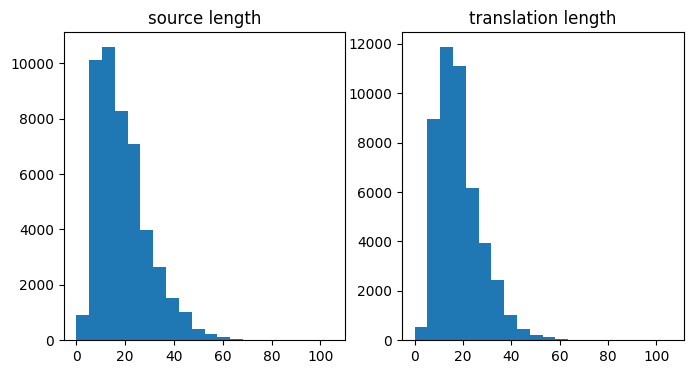

In [72]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

### Encoder-decoder model (1 point)

The code below contains a template for a simple encoder-decoder model: single GRU encoder/decoder, no attention or anything. This model is implemented for you as a reference and a baseline for your homework assignment.

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [74]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__() # initialize base class to track sub-layers, parameters, etc.

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]

        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0]

        prev_emb = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(prev_emb, prev_gru0_state)
        output_logits = self.logits(new_dec_state)

        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states

In [75]:
# debugging area
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [76]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
color@@ not@@ gage courty@@ yevpatoriya form form maria form maria azzur@@ camp ß ami core sampled partial diving read les@@ structed fen property dunes way
color@@ not@@ gage courty@@ yevpatoriya form form maria form maria azzur@@ camp ß ami core sampled partial diving read les@@ structed fen property dunes way
color@@ not@@ gage courty@@ yevpatoriya form form maria form maria azzur@@ camp ß ami core sampled partial diving read les@@ structed fen property dunes way


### Training loss (1 point)

Our training objective is almost the same as it was for neural language models:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

where $|D|$ is the __total length of all sequences__, including BOS and first EOS, but excluding PAD.

In [77]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """

    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_one_hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1)

    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_one_hot).sum(dim=-1)

    # average cross-entropy over tokens where mask == True
    return -(logp_out * mask).sum() / mask.sum()

In [78]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.5600, device='cuda:0', grad_fn=<DivBackward0>)


### Evaluation: BLEU

Machine translation is commonly evaluated with [BLEU](https://en.wikipedia.org/wiki/BLEU) score. This metric simply computes which fraction of predicted n-grams is actually present in the reference translation. It does so for n=1,2,3 and 4 and computes the geometric average with penalty if translation is shorter than reference.

While BLEU [has many drawbacks](http://www.cs.jhu.edu/~ccb/publications/re-evaluating-the-role-of-bleu-in-mt-research.pdf), it still remains the most commonly used metric and one of the simplest to compute.

In [79]:
from nltk.translate.bleu_score import corpus_bleu

def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    Note: if you're serious about reporting your results, use https://pypi.org/project/sacrebleu
    """
    with torch.inference_mode():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

In [80]:
compute_bleu(model, dev_inp, dev_out)

0.002180232438889612

### Training loop

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

In [81]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BasicModel(inp_voc, out_voc).to(device)
learning_rate = 1e-3
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 32

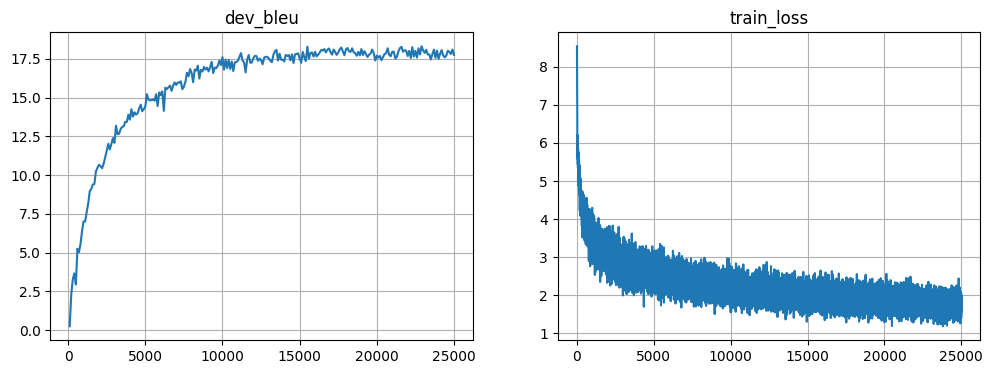

Mean loss=1.722


100%|██████████| 25000/25000 [20:42<00:00, 20.13it/s]


bleu,▁▂▃▆▆▆▆▇▇▇▇▇▇███████████████████████████
loss,█▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▂▂▂▂▂▁▁
bleu,17.75951
loss,1.97985


In [82]:
run = wandb.init(project="encoder-decoder")
config = run.config
config.learning_rate = learning_rate
config.batch_size = batch_size

for _ in trange(25_000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    # YOUR CODE: training step using batch_inp and batch_out
    opt.zero_grad()

    loss_t = compute_loss(model, batch_inp, batch_out)

    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))
    run.log({"loss": loss_t.item()})

    if step % 100 == 0:
        bleu = compute_bleu(model, dev_inp, dev_out)
        metrics['dev_bleu'].append((step, bleu))
        run.log({"bleu": bleu})

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
run.finish()
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [83]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "We kind of need a higher bleu BLEU from you. Kind of right now."

In [84]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
you will find a shared shared kitchen , shared and a shared kitchen .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
bike rental and free parking are available at the property .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
catania is 26 km from the property .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
offering a garden , a garden and a garden , this apartment features a garden with a terrace , and a garden with a terrace .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
sao paulo - saint - lazare in the centre of wrocław - sur - mer is a self - catering accommodation located in the centre of rome .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
featuring a shower , pri

### Your Attention Required

In this section we want you to improve over the basic model by implementing a simple attention mechanism.

This is gonna be a two-parter: building the __attention layer__ and using it for an __attentive seq2seq model__.

### Attention layer (3 points)

Here you will have to implement a layer that computes a simple additive attention:

Given encoder sequence $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ and a single decoder state $h^d$,

* Compute logits with a 2-layer neural network
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Get probabilities from logits,
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

You can learn more about attention layers in the lecture slides or [from this post](https://distill.pub/2016/augmented-rnns/).

In [85]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size, activ=torch.tanh):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units
        self.activ = activ       # attention layer hidden nonlinearity

        # Линейные преобразования для encoder и decoder
        self.linear_enc = nn.Linear(enc_size, hid_size, bias=False)
        self.linear_dec = nn.Linear(dec_size, hid_size, bias=False)
        # Вектор v для вычисления скалярных логитов
        self.v = nn.Linear(hid_size, 1, bias=False)


    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """

        # Compute logits: a_t = v^T * tanh(W_e * h_e + W_d * h_d)
        projected_enc = self.linear_enc(enc)  # [batch, seq_len, hid_size]
        projected_dec = self.linear_dec(dec)  # [batch, hid_size]

        # Складываем с broadcasting
        combined = self.activ(projected_enc + projected_dec.unsqueeze(1))  # [batch, seq_len, hid_size]
        logits = self.v(combined).squeeze(-1)  # [batch, seq_len]

        # Apply mask - if mask is False/0, logits should be -inf
        if inp_mask is not None:
            logits = logits.masked_fill(~inp_mask, -1e9)

        # Compute attention probabilities (softmax)
        probs = F.softmax(logits, dim=-1)  # [batch, seq_len]

        # Compute attention response: weighted sum of encoder states
        attn = torch.bmm(probs.unsqueeze(1), enc).squeeze(1)  # [batch, enc_size]

        return attn, probs



### Seq2seq model with attention (3 points)

You can now use the attention layer to build a network. The simplest way to implement attention is to use it in decoder phase:

![img](https://i.imgur.com/6fKHlHb.png)

_image from distill.pub [article](https://distill.pub/2016/augmented-rnns/)_

On every step, use __previous__ decoder state to obtain attention response. Then feed concat this response to the inputs of next attention layer.

The key implementation detail here is __model state__. Put simply, you can add any tensor into the list of `encode` outputs. You will then have access to them at each `decode` step. This may include:
* Last RNN hidden states (as in basic model)
* The whole sequence of encoder outputs (to attend to) and mask
* Attention probabilities (to visualize)

_There are, of course, alternative ways to wire attention into your network and different kinds of attention. Take a look at [this](https://arxiv.org/abs/1609.08144), [this](https://arxiv.org/abs/1706.03762) and [this](https://arxiv.org/abs/1808.03867) for ideas. And for image captioning/im2latex there's [visual attention](https://arxiv.org/abs/1502.03044)_

In [86]:
class AttentiveModel(BasicModel):
    def __init__(self, name, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        nn.Module.__init__(self)  # initialize base class to track sub-layers, trainable variables, etc.
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        # YOUR CODE: initialize layers
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))
        self.attn = AttentionLayer(hid_size, hid_size, attn_size)

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """

        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        mask = self.inp_voc.compute_mask(inp)

        enc_seq, _ = self.enc0(inp_emb)

        # Находим реальное последнее состояние
        lengths = mask.to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq), device=inp.device), lengths]

        dec_start = self.dec_start(last_state)

        # Первый attention
        first_attn, first_attn_probs = self.attn(enc_seq, dec_start, mask)

        # State: [dec_state, enc_seq, mask, attn_probs]
        first_state = [dec_start, enc_seq, mask, first_attn_probs]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        prev_dec_state, enc_seq, mask, prev_attn_probs = prev_state

        # Получаем attention response на основе предыдущего состояния
        attn_response, attn_probs = self.attn(enc_seq, prev_dec_state, mask)

        # Конкатенируем эмбеддинг токена с attention response
        prev_emb = self.emb_out(prev_tokens)
        dec_input = torch.cat([prev_emb, attn_response], dim=-1)

        # Обновляем состояние декодера
        new_dec_state = self.dec0(dec_input, prev_dec_state)
        output_logits = self.logits(new_dec_state)

        new_state = [new_dec_state, enc_seq, mask, attn_probs]
        return new_state, output_logits


### Training attentive model

Please reuse the infrastructure you've built for the regular model. I hope you didn't hard-code anything :)

In [87]:
# YOUR CODE: create AttentiveModel and training utilities
attn_metrics = {'train_loss': [], 'dev_bleu': []}

attentive_model = AttentiveModel('v1.0',inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128).to(device)
attn_learning_rate = 1e-3
attn_opt = torch.optim.Adam(attentive_model.parameters(), lr=attn_learning_rate)
attn_batch_size = 32

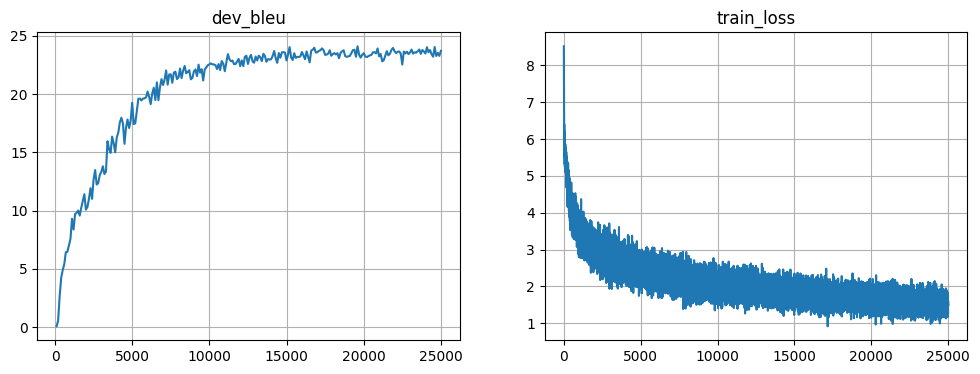

100%|██████████| 25000/25000 [43:37<00:00,  9.55it/s]

Step 25000, Mean loss=1.468, BLEU=23.71


bleu,▁▂▂▂▃▅▅▅▅▅▆▅▆▆▇▇█▇█▇████████████████████
loss,█▅▄▅▅▃▃▃▃▃▂▃▃▃▃▂▃▃▂▃▂▃▂▃▂▂▃▂▂▂▂▁▂▂▁▁▂▂▁▂
bleu,23.70509
loss,1.58836


In [88]:
# YOUR CODE: training loop (don't forget to log metrics in wandb)
# Training loop
run = wandb.init(project="encoder-decoder", name="attentive-model")
config = run.config
config.learning_rate = attn_learning_rate
config.batch_size = attn_batch_size
config.model = "AttentiveModel"

for _ in trange(25_000):
    step = len(attn_metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=attn_batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    attn_opt.zero_grad()
    loss_t = compute_loss(attentive_model, batch_inp, batch_out)
    loss_t.backward()
    attn_opt.step()

    attn_metrics['train_loss'].append((step, loss_t.item()))
    run.log({"loss": loss_t.item()})

    if step % 100 == 0:
        bleu = compute_bleu(attentive_model, dev_inp, dev_out)
        attn_metrics['dev_bleu'].append((step, bleu))
        run.log({"bleu": bleu})

        clear_output(True)
        plt.figure(figsize=(12, 4))
        for i, (name, history) in enumerate(sorted(attn_metrics.items())):
            plt.subplot(1, len(attn_metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print(f"Step {step}, Mean loss={np.mean(attn_metrics['train_loss'][-10:], axis=0)[1]:.3f}, BLEU={bleu:.2f}")

run.finish()

In [89]:
# YOUR CODE: measure final BLEU
final_bleu = compute_bleu(attentive_model, dev_inp, dev_out)
print(f"Final BLEU: {final_bleu:.2f}")
assert final_bleu > 15, "BLEU should be > 15"

Final BLEU: 23.71


### Visualizing model attention (1 point)

After training the attentive translation model, you can check it's sanity by visualizing its attention weights.

We provided you with a function that draws attention maps using [`Bokeh`](https://bokeh.pydata.org/en/latest/index.html). Once you managed to produce something better than random noise, please save at least 3 attention maps and __submit them to classroom__ alongside this notebook to get the max grade. Saving bokeh figures as __cell outputs is not enough!__ (sometimes we can't see saved bokeh figures in classroom). You can save bokeh images as screenshots or using this button:

![bokeh_panel](https://github.com/yandexdataschool/nlp_course/raw/2019/resources/bokeh_panel.png)

__Note:__ you're not locked into using bokeh. If you prefer a different visualization method, feel free to use that instead of bokeh.

In [90]:
import bokeh.plotting as pl
import bokeh.models as bm
from bokeh.io import output_notebook, show
output_notebook()

def draw_attention(inp_line, translation, probs):
    """ An intentionally ambiguous function to visualize attention weights """
    inp_tokens = inp_voc.tokenize(inp_line)
    trans_tokens = out_voc.tokenize(translation)
    probs = probs[:len(trans_tokens), :len(inp_tokens)]

    fig = pl.figure(x_range=(0, len(inp_tokens)), y_range=(0, len(trans_tokens)),
                    x_axis_type=None, y_axis_type=None, tools=[])
    fig.image([probs[::-1]], 0, 0, len(inp_tokens), len(trans_tokens))

    fig.add_layout(bm.LinearAxis(axis_label='source tokens'), 'above')
    fig.xaxis.ticker = np.arange(len(inp_tokens)) + 0.5
    fig.xaxis.major_label_overrides = dict(zip(np.arange(len(inp_tokens)) + 0.5, inp_tokens))
    fig.xaxis.major_label_orientation = 45

    fig.add_layout(bm.LinearAxis(axis_label='translation tokens'), 'left')
    fig.yaxis.ticker = np.arange(len(trans_tokens)) + 0.5
    fig.yaxis.major_label_overrides = dict(zip(np.arange(len(trans_tokens)) + 0.5, trans_tokens[::-1]))

    show(fig)

In [91]:
inp = dev_inp[::500]

trans, states = attentive_model.translate_lines(inp)

# select attention probs from model state (you may need to change this for your custom model)
# attention_probs below must have shape [batch_size, translation_length, input_length], extracted from states
# e.g. if attention probs are at the end of each state, use np.stack([state[-1] for state in states], axis=1)

attention_probs = np.stack([state[-1].detach().cpu().numpy() for state in states], axis=1)

In [92]:
for i in range(5):
    draw_attention(inp[i], trans[i], attention_probs[i])

# Does it look fine already? don't forget to save images for classroom!

Сохраню скрины карт в пдф и приложу в классрум на всякий случай


__Note:__ If the attention maps are not iterpretable, try starting encoder from zeros (instead of dec_start), forcing model to use attention.

# Part 2. Named Entity Recognition
Here we're gonna solve the problem of named entity recognition. Here's what it does in one picture:

![nlp-task-named-entity-recognition.png](https://mobidev.biz/wp-content/uploads/2019/12/nlp-task-named-entity-recognition.png)

For each word, in a sentence, your model should predict a named entity class: person, organization, location and so on

In this part of assignment we will use a bit higher level DL interface, we won't write any loops and etc, but we will do some work around the data (and use LoRA for fine-tuning)

## Dataset exploration (0.5 point)

In [93]:
!pip install datasets -q

We will work with [multinerd](https://huggingface.co/datasets/Babelscape/multinerd) dataset from the 🤗 HuggingFace hub, specifically with its russian subset. NB: dataset was created automatically, not manualy, therefore it may contain some labeling mistakes obvious for people. It is based on wiki sentences and has 15 NER categories:
- Person (PER)
- Location (LOC)
- Organization (ORG)
- Animal (ANIM)
- Biological entity (BIO)
- Celestial Body (CEL)
- Disease (DIS)
- Event (EVE)
- Food (FOOD)
- Instrument (INST)
- Media (MEDIA)
- Plant (PLANT)
- Mythological entity (MYTH)
- Time (TIME)
- Vehicle (VEHI)

The format of all dataset follows popular [IOB format](https://en.wikipedia.org/wiki/Inside–outside–beginning_(tagging)). The B- prefix before a tag indicates that the tag is the beginning of a chunk, and an I- prefix before a tag indicates that the tag is inside a chunk. The B- tag is used only when a tag is followed by a tag of the same type without O tokens between them. An O tag indicates that a token belongs to no chunk. Therefore there we have 31 named entities.

To load the dataset, we use the `load_dataset()` method from the 🤗 Datasets library (don't worry about three last progress bars)

In [94]:
from datasets import load_dataset

raw_datasets = load_dataset("Babelscape/multinerd", verification_mode="no_checks")

In [95]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'lang'],
        num_rows: 1339200
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'lang'],
        num_rows: 167400
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'lang'],
        num_rows: 167993
    })
})

In [96]:
raw_datasets['train'][0]

{'tokens': ['2002',
  'ging',
  'er',
  'ins',
  'Ausland',
  'und',
  'wechselte',
  'für',
  '750.000',
  'Pfund',
  'Sterling',
  'zu',
  'Manchester',
  'City',
  '.'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0],
 'lang': 'de'}

Filter dataset by language

In [97]:
for dataset_name in raw_datasets:
    raw_datasets[dataset_name] = raw_datasets[dataset_name].filter(lambda example: example['lang'] == 'ru')
    raw_datasets[dataset_name] = raw_datasets[dataset_name].remove_columns('lang')

In [98]:
assert len(raw_datasets['train']) == 66240
assert len(raw_datasets['validation']) == 8280
assert len(raw_datasets['test']) == 8338

In [99]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 66240
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 8280
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 8338
    })
})

In [100]:
raw_datasets['train'][0]

{'tokens': ['Существовали',
  'виды',
  ',',
  'напоминавшие',
  'вследствие',
  'конвергентной',
  'эволюции',
  'современных',
  'лошадей',
  ',',
  'верблюдов',
  'и',
  'носорогов',
  ',',
  'не',
  'будучи',
  'их',
  'родственниками',
  '.'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0]}

Let's see the `ner_tags` description

In [101]:
raw_datasets['train'].features['ner_tags']

List(Value('int64'))

It is just indices, so to make it readable we should apply [mapping](https://huggingface.co/datasets/Babelscape/multinerd#dataset-structure)

In [102]:
tag2idx = {
    "O": 0,
    "B-PER": 1,
    "I-PER": 2,
    "B-ORG": 3,
    "I-ORG": 4,
    "B-LOC": 5,
    "I-LOC": 6,
    "B-ANIM": 7,
    "I-ANIM": 8,
    "B-BIO": 9,
    "I-BIO": 10,
    "B-CEL": 11,
    "I-CEL": 12,
    "B-DIS": 13,
    "I-DIS": 14,
    "B-EVE": 15,
    "I-EVE": 16,
    "B-FOOD": 17,
    "I-FOOD": 18,
    "B-INST": 19,
    "I-INST": 20,
    "B-MEDIA": 21,
    "I-MEDIA": 22,
    "B-MYTH": 23,
    "I-MYTH": 24,
    "B-PLANT": 25,
    "I-PLANT": 26,
    "B-TIME": 27,
    "I-TIME": 28,
    "B-VEHI": 29,
    "I-VEHI": 30,
}

idx2tag = {v: k for k, v in tag2idx.items()}

There is a fancy visualizer in `spacy` nlp library we can adapt for custom dataset.

In [103]:
from spacy import displacy
import typing as tp

def ner_render(tokens: tp.Sequence[str], ner_tags: tp.Sequence[int], title: tp.Optional[str] = None, **kwargs):
    pos = 0
    ents = []
    for word, tag_ in zip(tokens, ner_tags):
        tag = idx2tag[tag_]
        if tag.startswith('B'):
            ents.append({
                "start": pos,
                "end": pos + len(word),
                "label": tag.split("-")[1]
            })
        elif tag.startswith('I'):
            ents[-1]["end"] = pos + len(word)
        pos += (len(word) + 1)
    displacy.render({
        "text": " ".join(tokens),
        "ents": ents,
        "title": title
    }, style="ent", manual=True, jupyter=True)

Et voilà!

In [104]:
for train_id in [50, 150, 300]:
    ner_render(**raw_datasets['train'][train_id], title = f'multinerd train[{train_id}]')

Let's count each type of tags

In [105]:
from itertools import chain
from collections import Counter

tag_counter = Counter()

# YOUR CODE HERE
for row in chain(raw_datasets['train'], raw_datasets['validation'], raw_datasets['test']):
    tag_counter.update(row['ner_tags'])


In [106]:
assert tag_counter[0] > (sum(tag_counter.values()) - tag_counter[0])

In [107]:
for idx, cntr in sorted(tag_counter.items(), key=lambda kv: kv[1], reverse=True):
    print(idx2tag[idx], cntr)

O 1210232
B-LOC 41293
I-PER 35068
B-PER 34693
I-EVE 10717
I-LOC 9817
I-ORG 9578
B-ORG 8035
B-ANIM 7912
B-EVE 5622
I-MEDIA 4593
B-PLANT 4303
B-MEDIA 3712
B-DIS 2717
B-TIME 2334
I-ANIM 2105
B-FOOD 1947
I-TIME 1620
B-CEL 1394
I-DIS 1293
I-PLANT 920
I-CEL 677
B-INST 450
B-MYTH 441
I-FOOD 396
B-VEHI 344
I-VEHI 274
I-INST 221
I-MYTH 153
B-BIO 19
I-BIO 9


## Dataset preparation (3 points)

It is time to tokenize out texts. We will use tokenizer of pretrained BERT. You can try [any model](https://huggingface.co/models) you want, but remember we will deal russian texts mostly (it is better if text splits in fewer amount of tokens)

In [108]:
from transformers import AutoTokenizer

model_checkpoint = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

To tokenize a pre-tokenized input, we can use our `tokenizer` as usual and just add `is_split_into_words=True`:

In [109]:
example = raw_datasets["train"][0]
inputs = tokenizer(example["tokens"], is_split_into_words=True)
print(len(inputs.tokens()), inputs.tokens())
print(len(example["ner_tags"]), example["ner_tags"])

24 ['[CLS]', 'Существовали', 'виды', ',', 'напомина', '##вшие', 'вследствие', 'конверг', '##ентной', 'эволюции', 'современных', 'лошадей', ',', 'верблюдов', 'и', 'носор', '##огов', ',', 'не', 'будучи', 'их', 'родственниками', '.', '[SEP]']
19 [0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0]


As we can see, the tokenizer added the special tokens used by the model (`[CLS]` at the beginning and `[SEP]` at the end) and left most of the words untouched. The word `напоминавшие`, however, was tokenized into two subwords, `напомина` and `##вшие`. This introduces a mismatch between our inputs and the labels: the list of labels has only 19 elements, whereas our input now has 24 tokens. Accounting for the special tokens is easy (we know they are at the beginning and the end), but we also need to make sure we align all the labels with the proper words.

To handle it we should know the relations between tokens and words.

In [110]:
print(len(inputs.word_ids()), inputs.word_ids())

24 [None, 0, 1, 2, 3, 3, 4, 5, 5, 6, 7, 8, 9, 10, 11, 12, 12, 13, 14, 15, 16, 17, 18, None]


With a tiny bit of work, we can then expand our label list to match the tokens:
- The first rule we’ll apply is that special tokens get a label of $-100$. This is because by default $-100$ is an index that is ignored in the loss function we will use (cross entropy)
- Secondly, each token gets the same label as the token that started the word it’s inside, since they are part of the same entity
- And the last case, for tokens inside a word but not at the beginning, we replace the B- with I- (since the token does not begin the entity)

In [111]:
def align_labels_with_tokens(labels: tp.Sequence[int], word_ids: tp.Sequence[int]):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            if word_id is None:
                label = -100
            else:
                label = labels[word_id]
        else:
            if word_id is None:
                label = -100
            else:
                label = labels[word_id]
                if label != -100 and label != 0:
                    tag_name = idx2tag[label]
                    if tag_name.startswith('B-'):
                        entity_type = tag_name[2:]
                        label = tag2idx[f'I-{entity_type}']

        new_labels.append(label)

    return new_labels

In [112]:
for idx in [42, 4224, 4242]:
    row = raw_datasets["train"][idx]
    labels = row["ner_tags"]

    inputs = tokenizer(row["tokens"], is_split_into_words=True)
    word_ids = inputs.word_ids()
    aligned_labels = align_labels_with_tokens(labels, word_ids)
    assert len(inputs.tokens()) == len(aligned_labels)
    assert aligned_labels[0] == -100
    assert aligned_labels[-1] == -100

Let’s try it out on our example sentence:

In [113]:
labels = example["ner_tags"]
word_ids = tokenizer(example["tokens"], is_split_into_words=True).word_ids()
aligned_labels = align_labels_with_tokens(labels, word_ids)
print(len(labels), labels)
print(len(aligned_labels), aligned_labels)

19 [0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0]
24 [-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]


To preprocess our whole dataset, we need to tokenize all the inputs and apply `align_labels_with_tokens()` on all the labels. To take advantage of the speed of our tokenizer, it’s best to tokenize lots of texts at the same time, so we’ll write a function that processes a list of examples and use the `Dataset.map()` method with the option `batched=True`. The only thing that is different from our previous example is that the `word_ids()` function needs to get the index of the example we want the word IDs of when the inputs to the tokenizer are lists of texts (or in our case, list of lists of words), so we add that too

In [114]:
def tokenize_and_align_labels(rows: tp.Sequence[tp.Dict[str, tp.Any]]):
    all_labels = rows["ner_tags"]
    tokenized_inputs = tokenizer(rows["tokens"], is_split_into_words=True)

    new_labels = []
    for i, labels in enumerate(all_labels):
        # YOUR CODE HERE
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

We can now apply all that preprocessing in one go on the other splits of our dataset:

In [115]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

Map:   0%|          | 0/66240 [00:00<?, ? examples/s]

Map:   0%|          | 0/8280 [00:00<?, ? examples/s]

Map:   0%|          | 0/8338 [00:00<?, ? examples/s]

Now our datasets look like this

In [116]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 66240
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 8280
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 8338
    })
})

Here:

`input_ids` - indices of input sequence tokens in the vocabulary

`token_type_ids` - segment token indices to indicate first and second portions of the inputs in NSP (Next Sentence Prediction) task. Indices are selected in [0, 1]: 0 corresponds to a sentence A token, 1 corresponds to a sentence B token. We don't need it today

`attention_mask` - mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]

That's all with preprocessing. To be honest with you, it was the hardest part ;)

## Padding

As our datasets are preprocessed we should create `data_collator` -- special function, which takes list of preprocessed sentences and return tensors (padding smaller sentences)

In [117]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

To test this on a few samples, we can just call it on a list of examples from our tokenized training set

In [118]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(4)])
batch["labels"]

tensor([[-100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    7,
            0,    7,    0,    0,    0,    0,    0,    0,    0,    0,    0, -100],
        [-100,    0,    0,    0,    0,    0,    0,    0,    1,    2,    2,    0,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
        [-100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    7,    0,    7,    8,    8,    0,    0,    0,    0,    0, -100],
        [-100,    0,    0,    0,    0,    0,    0,    5,    0,    0,    0,    5,
            6,    0,    0,    5,    6,    0, -100, -100, -100, -100, -100, -100]])

Let’s compare this to the labels in our dataset

In [119]:
for i in range(4):
    print(tokenized_datasets["train"][i]["labels"])

[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]
[-100, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, -100]
[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 7, 8, 8, 0, 0, 0, 0, 0, -100]
[-100, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 6, 0, 0, 5, 6, 0, -100]


As we see the second and the fourth sententes were padded to the length of the first and the third senteces

## Metrics

We also should define metrics we want to evaluate to check quality of model. We will need to define a `compute_metrics()` function that takes the arrays of predictions and labels, and returns a dictionary with the metric names and values.

The traditional framework used to evaluate token classification prediction is [seqeval](https://github.com/chakki-works/seqeval). To use this metric, we first need to install the seqeval library

In [120]:
!pip install evaluate seqeval -q

In [121]:
import evaluate

metric = evaluate.load("seqeval")

This `compute_metrics()` function first takes the argmax of the logits to convert them to predictions (as usual, the logits and the probabilities are in the same order, so we don’t need to apply the softmax). Then we have to convert both labels and predictions from integers to strings (`seqeval` works with strings, not with indexes). We remove all the values where the label is $-100$, then pass the results to the `metric.compute()` method:

In [122]:
import numpy as np

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[idx2tag[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [idx2tag[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
        # all_metrics also contains metrics inside each of the labels, you can track them too
    }

## BERT (0.5 - 3 points)

The sequence labeling task is a degenerate case of the seq2seq task: we need to map a sequence of words to a sequence of labels (tags) of **the same length**.

In case of BERT we want to get a vector of probabilities of labels for each input token. The simplest way to make it is just feed output token embeddings to Linear layer.

`transformers` class `BertForTokenClassification` works just like this.

![image.png](https://d2l.ai/_images/bert-tagging.svg)

Image from FastAI article: https://d2l.ai/chapter_natural-language-processing-applications/finetuning-bert.html

In [123]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,  # we declared it earlier, with tokenizer
    id2label=idx2tag,
    label2id=tag2idx,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The last layer `classifier` was changed as we have different classes in our task

In [124]:
model.config.num_labels

31

As we would like to use HuggingFace training API now we should specify training argumets

In [125]:
from transformers import TrainingArguments

experiment_name = "rubert-finetuned-ner"
args = TrainingArguments(
    output_dir=experiment_name,
    eval_strategy="epoch",  # evaluate metrics every epoch
    save_strategy="epoch",  # save model checkpoints every epoch
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="wandb",
    logging_steps=100,
    run_name=experiment_name,
)

Once this done, let's begin the process (relax and drink a cup of tea)

In [126]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()
wandb.finish()

/tmp/ipython-input-2567881876.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.055700,0.060154,0.913904,0.899273,0.906529,0.979383
2,0.042900,0.060279,0.924207,0.935964,0.930049,0.982019
3,0.024200,0.065814,0.925957,0.941502,0.933665,0.982661


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,▁▁█
eval/precision,▁▇█
eval/recall,▁▇█
eval/runtime,▁▂█
eval/samples_per_second,█▇▁
eval/steps_per_second,█▇▁
train/epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇███
+3,...


It is playing time! Try your best to achive highest metrics!

It is graded task, supass `Overall F1`:
- $0.88$ to get $0.5$ point
- $0.90$ to get $1.5$ points
- best result will be awarded with $3$ points

## Custom LoRA (1 point)

Training some DL models is time-, GPU- and data- consuming, e.g. imagine fine-tuning LLM's... Instead, you can use low-rank adapters based on [LoRA paper](https://arxiv.org/pdf/2106.09685.pdf).

The core idea is to add low-rank adapters __in parallel with attention projection matrices,__ like this:
<center><img src="https://i.imgur.com/6bQLNiG.png" width=240px></center>

In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LoRALayer(nn.Module):
    """Wraps a linear layer with LoRA-like adapter. Wraps an existing OPT linear layer"""
    def __init__(self, module: nn.Linear, rank: int):
        super().__init__()
        self.module = module
        self.adapter_A = nn.Parameter(torch.empty(module.in_features, rank, device=module.weight.device))
        nn.init.kaiming_uniform_(self.adapter_A, a=5 ** 0.5)
        self.adapter_B = nn.Parameter(torch.zeros(rank, module.out_features, device=module.weight.device))

    def forward(self, input):
        # Apply self.module and LoRA adapter, return the sum (base module outputs + adapter outputs)
        lora_output = (input @ self.adapter_A) @ self.adapter_B
        return self.module(input) + lora_output


In [128]:
# test your implementation
test_linear = nn.Linear(128, 128)
test_linear.weight.data[...] = torch.eye(128)
test_adapter = LoRALayer(test_linear, rank=8)

assert torch.allclose(test_adapter(torch.ones(1, 1, 128)), test_linear.bias + 1), "please check your forward pass"

test_adapter.adapter_A.data[...] = torch.linspace(0.1, -0.5, 128 * 8).view(128, 8)
test_adapter.adapter_B.data[...] = torch.linspace(0.5, -0.1, 128 * 8).view(8, 128)
test_linear.bias.data[...] = torch.linspace(1., -1., 128)

dummy_loss = F.mse_loss(test_adapter(torch.ones(1, 128) / 128), torch.linspace(-1, 1, 128).unsqueeze(0))
assert torch.allclose(dummy_loss, torch.tensor(1.3711389), rtol=0, atol=1e-4)
dummy_loss.backward()
assert all(w.grad is not None for w in [test_adapter.adapter_A, test_adapter.adapter_B]), "some adapter weights have no grad"
assert torch.allclose(test_adapter.adapter_A.grad.sum(), torch.tensor(-0.60158), rtol=0, atol=1e-4), "bad grad w.r.t. A"
assert torch.allclose(test_adapter.adapter_B.grad.sum(), torch.tensor(0.9931), rtol=0, atol=1e-4), "bad grad w.r.t. B"
# note: bad grad means that your code is different from LoRA paper OR that your code is not autograd-friendly (e.g. no_grad)
del dummy_loss, test_linear, test_adapter
print("All tests passed!")

All tests passed!


Now let's apply it to our BERT!

In [129]:
custom_lora_model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=idx2tag,
    label2id=tag2idx,
)

# freeze pretrained weights
# YOUR CODE HERE
for param in custom_lora_model.base_model.parameters():
    param.requires_grad = False

Some weights of BertForTokenClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [130]:
for name, module in custom_lora_model.named_modules():
    if 'BertSdpaSelfAttention' in repr(type(module)):
        module.query = LoRALayer(module.query, rank=8)
        module.key = LoRALayer(module.key, rank=8)
        module.value = LoRALayer(module.value, rank=8)

assert sum(isinstance(module, LoRALayer) for module in custom_lora_model.modules()) == 36  # for DeepPavlov/rubert-base-cased

In [131]:
experiment_name = "rubert-custom-lora-ner"
args = TrainingArguments(
    output_dir=experiment_name,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="wandb",
    logging_steps=100,
    run_name=experiment_name,
)

In [132]:
from transformers import Trainer
trainer = Trainer(
    model=custom_lora_model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()
wandb.finish()

/tmp/ipython-input-2557494535.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.118600,0.101003,0.829898,0.853669,0.841616,0.967379
2,0.095600,0.085923,0.840872,0.891225,0.865317,0.970713
3,0.092900,0.081553,0.854724,0.890966,0.872468,0.971985


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▃▁
eval/precision,▁▄█
eval/recall,▁██
eval/runtime,▅▁█
eval/samples_per_second,▄█▁
eval/steps_per_second,▄█▁
train/epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
train/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
+3,...


Try to achieve at least `Overall F1` $= 0.8$

As we made LoRA layers only for attention projections, it may perform worse than fully finetuned model, but you can try to make LoRA for all linear layers. Also rank of LoRA plays crucial role while using small values.

Also you can try bigger models to achieve higher scores, as with LoRA it costs you less GPU GB

## PEFT LoRA (0.5 point)

In real life you don't want to create `LoRALayer` each time, so you will use libararies. One of the most popular is [`PEFT`](https://github.com/huggingface/peft) (Parameter Efficient Fine-Tuning)

In [133]:
!pip install peft -q

Now we just need to wrap our model and set LoRA arguments

In [134]:
from peft import get_peft_model, LoraConfig, TaskType

peft_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS,
    inference_mode=False,
    r=8,  # rank of LoRA
    lora_alpha=32,  # scaling factor
    lora_dropout=0.1,  # dropout is commonly used in many LoRA implementations
)

peft_lora_model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=idx2tag,
    label2id=tag2idx,
)
peft_lora_model = get_peft_model(model, peft_config)
peft_lora_model.print_trainable_parameters()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 318,751 || all params: 177,605,438 || trainable%: 0.1795


Only 0.18% of params is trainable -- much easier to optimize

That's all! Now try to train it

In [135]:
experiment_name = "rubert-peft-lora-ner"
args = TrainingArguments(
    output_dir=experiment_name,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="wandb",
    logging_steps=100,
    run_name=experiment_name,
)

trainer = Trainer(
    model=peft_lora_model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()
wandb.finish()

/tmp/ipython-input-1329356644.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.013200,0.067001,0.923416,0.943233,0.933219,0.982406


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.013200,0.067001,0.923416,0.943233,0.933219,0.982406
2,0.012500,0.067428,0.923351,0.943406,0.933271,0.982312
3,0.022500,0.067739,0.924958,0.942887,0.933836,0.982468


eval/accuracy,▅▁█
eval/f1,▁▂█
eval/loss,▁▅█
eval/precision,▁▁█
eval/recall,▆█▁
eval/runtime,█▁▁
eval/samples_per_second,▁██
eval/steps_per_second,▁██
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇██
train/global_step,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
+3,...


## Visualize results (1 point)

Compare predictions of your models with groud truth, to pretty visualizing try `ner_render()`. What type of mistakes do your models make?

In [143]:
import torch
import random
from transformers import AutoTokenizer, AutoModelForTokenClassification
from peft import get_peft_model, LoraConfig, TaskType

model_checkpoint = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def get_word_level_predictions(token_predictions, word_ids):
    word_to_token_map = {}
    for token_idx, word_idx in enumerate(word_ids):
        if word_idx is not None and word_idx not in word_to_token_map:
            word_to_token_map[word_idx] = token_idx
    sorted_word_indices = sorted(word_to_token_map.keys())
    word_level_predictions = []
    for word_idx in sorted_word_indices:
        first_token_idx = word_to_token_map[word_idx]
        word_level_predictions.append(token_predictions[first_token_idx])
    return word_level_predictions

models_to_compare = [
    ("Full Finetuned", model),
    ("Custom LoRA", custom_lora_model),
    ("PEFT LoRA", peft_lora_model)
]

for name, eval_model in models_to_compare:
    if eval_model is not None:
        eval_model.eval()
        eval_model.to(device)

indices = [15, 42, 52, 100, 350, 1200]

for i in indices:
    example = raw_datasets['validation'][i]
    tokens = example['tokens']
    gt_tags = example['ner_tags']

    print(f"\nПример с индексом: {i}")
    ner_render(tokens, gt_tags, title="Правильные ответы")

    for model_name, eval_model in models_to_compare:

        inputs = tokenizer(tokens, is_split_into_words=True, return_tensors='pt').to(device)
        word_ids = inputs.word_ids(batch_index=0)

        with torch.no_grad():
            outputs = eval_model(**inputs)

        predictions = torch.argmax(outputs.logits, dim=-1).squeeze().cpu().numpy()

        pred_tags = get_word_level_predictions(predictions, word_ids)

        ner_render(tokens, pred_tags, title=f"Предсказаиня модели: {model_name}")
    print("-" * 80)



Пример с индексом: 15


--------------------------------------------------------------------------------

Пример с индексом: 42


--------------------------------------------------------------------------------

Пример с индексом: 52


--------------------------------------------------------------------------------

Пример с индексом: 100


--------------------------------------------------------------------------------

Пример с индексом: 350


--------------------------------------------------------------------------------

Пример с индексом: 1200


--------------------------------------------------------------------------------


Ну модели показывают правильные результаты, ура победа. \

---
Анекдот \
Сидит мужик на рельсах, смеется и плачет, подходит другой мужик и спрашивает:
- Ты чего плачешь?
- Поезд ногу переехал
- а смеешься почему?
- а я ему подножку поставил...